# Message to the future

Many data loading scripts in this notebook were somewhat single-use, best to rewrite data loading from scratch in case you rerun the experiments.

The results were fetched and saved as csv files in `scripts/results/` directory. You can go straight to "Load data from disk" section if you want to load them. Should be enough to test or figure out how the actual plotting scripts work. 

# Requirements

In [5]:
from math import isnan

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

dataset_match = {
    "fbirn": "FBIRN ICA",
    "fbirn_roi": "FBIRN Schaefer 200 ROI",
    "bsnip": "BSNIP ICA",
    "cobre": "COBRE ICA",

    "abide": "ABIDE ICA 569 subjects",
    "abide_869": "ABIDE ICA",
    "abide_roi": "ABIDE Schaefer 200 ROI",

    "oasis": "OASIS ICA",
    "adni": "ADNI ICA",

    "hcp": "HCP ICA",
    "hcp_roi": "HCP Schaefer 200 ROI Extended",
    "hcp_roi_752": "HCP Schaefer 200 ROI",
    "hcp_schaefer": "HCP Schaefer 200 ROI w/o denoising",
    "hcp_non_mni_2": "HCP Deskian/Killiany ROI in Orig space",
    "hcp_mni_3": "HCP Deskian/Killiany ROI",

    "ukb": "UK Biobank (Sex) ICA",
    "ukb_age_bins": "UK Biobank (Age-Sex) ICA",

    "hcp_time": "HCP ICA Time",

    "fbirn_cobre": "FBIRN X COBRE",
    "fbirn_bsnip": "FBIRN X BSNIP",
    "cobre_fbirn": "COBRE X FBIRN",
    "cobre_bsnip": "COBRE X BSNIP",
    "bsnip_fbirn": "BSNIP X FBIRN",
    "bsnip_cobre": "BSNIP X COBRE",

    "oasis_adni": "OASIS X ADNI",
    "adni_oasis": "ADNI X OASIS",
}

model_match = {
    "mlp": "meanMLP",
    "rearranged_mlp": "meanMLP",
    "attn_mlp": "Attention MLP",
    "lstm": "LSTM",
    "mean_lstm": "meanLSTM",
    "transformer": "Transformer w/o PE",
    "mean_transformer": "meanTransformer w/o PE",
    "pe_transformer": "Transformer",
    "mean_pe_transformer": "meanTransformer",
    "milc": "MILC",
    "dice": "DICE",
    "bnt": "BNT",
    "fbnetgen": "FBNetGen",
    "brainnetcnn": "BrainNetCNN",
    "lr": "LR",
    "bolT": "BolT",
    "glacier": "Glacier",
}

def fix_run(run, dataset):
    for _, row in run.history().iterrows():
        if f"{dataset}score" in row and f"{dataset}accuracy" in row and "training_time" in row and f"{dataset}average_time" in row:
            if row[f"{dataset}score"] is not None and row[f"{dataset}accuracy"] is not None and row["training_time"] is not None and row[f"{dataset}average_time"] is not None:
                if not isnan(row[f"{dataset}score"]) and not isnan(row[f"{dataset}accuracy"]) and not isnan(row["training_time"]) and not isnan(row[f"{dataset}average_time"]):
                    auc = row[f"{dataset}score"]
                    acc = row[f"{dataset}accuracy"]
                    train_t = row["training_time"]
                    inf_t= row[f"{dataset}average_time"]
                    break
    
    run.summary[f"{dataset}score"] = auc
    run.summary[f"{dataset}accuracy"] = acc
    run.summary["training_time"] = train_t
    run.summary[f"{dataset}average_time"] = inf_t

    run.summary.update()

    return auc, acc, train_t, inf_t

def load_run(proj_name, dataset):
    if dataset is not None:
        dataset += "_"
    else:
        dataset = "test_"

    api = wandb.Api(timeout=19)
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list = []
    runs_list = []
    config_list = []
    for i, run in enumerate(runs):
        summary_list.append(run.summary._json_dict)
        config_list.append(run.config)
        runs_list.append(run)


    AUC_score = []
    accuracy = []
    train_time = []
    inference_time = []
    params = []
    shuffling = []

    for i, summary in enumerate(summary_list):
        everything_is_cool = True
        everything_is_cool = everything_is_cool and f"{dataset}score" in summary and summary[f"{dataset}score"] is not None
        everything_is_cool = everything_is_cool and f"{dataset}accuracy" in summary and summary[f"{dataset}accuracy"] is not None
        everything_is_cool = everything_is_cool and "training_time" in summary and summary["training_time"] is not None
        everything_is_cool = everything_is_cool and f"{dataset}average_time" in summary and summary[f"{dataset}average_time"] is not None

        if everything_is_cool:
            AUC_score.append(summary[f"{dataset}score"])
            accuracy.append(summary[f"{dataset}accuracy"])
            train_time.append(summary["training_time"])
            inference_time.append(summary[f"{dataset}average_time"])
        else:
            print(f"Run {i} summary is broken, fixing it")
            auc, acc, train_t, inf_t = fix_run(runs_list[i], dataset)
            AUC_score.append(auc)
            accuracy.append(acc)
            train_time.append(train_t)
            inference_time.append(inf_t)

        if "params" in summary:
            params.append(summary["params"])
        else:
            params.append(None)

        if "permute" in config_list[i]["general"]:
            if config_list[i]["general"]["permute"] == False:
                shuffling.append("None")
            else:
                shuffling.append(config_list[i]["general"]["permute"])
        else:
            shuffling.append("None")
    
    return AUC_score, accuracy, train_time, inference_time, params, shuffling

def load_metrics(paths_dict, ds_dict, model_dict):
    data_list = []

    for model_name in paths_dict:
        print(model_name)
        for dataset_name in paths_dict[model_name]:
            print("\t ", dataset_name)
            
            if len(paths_dict[model_name][dataset_name]) == 2:
                path = paths_dict[model_name][dataset_name][0]
                dataset = paths_dict[model_name][dataset_name][1]
            elif len(paths_dict[model_name][dataset_name]) == 1:
                path = paths_dict[model_name][dataset_name][0]
                dataset = "test"
            else:
                raise NotImplementedError()

            print("\t\t sub_dataset:", dataset)

            AUC_score, accuracy, train_time, inference_time, params, shuffling = load_run(path, dataset)
            
            if dataset != "test":
                dataset = dataset_name + "_" + dataset
            else:
                dataset = dataset_name
            length = len(AUC_score)

            data_list.append(
                pd.DataFrame(
                    {
                        "Model": [model_dict[model_name]]*length,
                        "Dataset": [ds_dict[dataset]]*length,
                        "AUROC": AUC_score,
                        "Accuracy": accuracy,
                        "Train time": train_time,
                        "Inference time": inference_time,
                        "Trainable params": params,
                        "Shuffling": shuffling,
                    }
                )
            )
    
    return pd.concat(data_list)


In [6]:
def test_run(proj_name, dataset):
    if dataset is not None:
        dataset += "_"
    else:
        dataset = "test_"

    api = wandb.Api(timeout=19)
    # Project is specified by <entity/project-name>

    try:
        runs = api.runs(f"pavalipopov/{proj_name}")
        summary_list = []
        runs_list = []
        config_list = []
        for i, run in enumerate(runs): 
            # print(f"Run {i}")
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files 
            summary_list.append(run.summary._json_dict)
            config_list.append(run.config)
            runs_list.append(run)
    except:
        print(proj_name)
        return

    global_cool = True

    count = 0
    for i, summary in enumerate(summary_list):
        everything_is_cool = True
        everything_is_cool = everything_is_cool and f"{dataset}score" in summary and summary[f"{dataset}score"] is not None
        everything_is_cool = everything_is_cool and f"{dataset}accuracy" in summary and summary[f"{dataset}accuracy"] is not None
        everything_is_cool = everything_is_cool and "training_time" in summary and summary["training_time"] is not None
        everything_is_cool = everything_is_cool and f"{dataset}average_time" in summary and summary[f"{dataset}average_time"] is not None

        if not everything_is_cool:
            try:
                fix_run(runs_list[i], dataset)
                count += 1
            except:
                global_cool = False
            # print(f"Run {i} summary is broken")
        else:
            count += 1
    
    if not global_cool or count != 50:
        print(proj_name)

def test_runs(paths_dict):

    print("Problematic runs:")

    for model_name in paths_dict:
        # print(model_name)
        for dataset_name in paths_dict[model_name]:
            # print("\t ", dataset_name)
            
            if len(paths_dict[model_name][dataset_name]) == 2:
                path = paths_dict[model_name][dataset_name][0]
                dataset = paths_dict[model_name][dataset_name][1]
            elif len(paths_dict[model_name][dataset_name]) == 1:
                path = paths_dict[model_name][dataset_name][0]
                dataset = "test"
            else:
                raise NotImplementedError()

            # print("\t\t sub_dataset:", dataset)

            test_run(path, dataset)

# Load data

## General results

In [3]:
datasets = [
    "fbirn", 
    "fbirn_roi",
    "bsnip",
    "cobre",
    "abide_869",
    "abide_roi",
    "oasis",
    "adni",
    "hcp",
    "hcp_roi_752",
    "ukb",
    "ukb_age_bins",
]
dataset_suffix = "_th"
models = [
    # "mlp",
    "lstm",
    # "transformer",
    "milc",
    "dice",
    "bnt",
    "fbnetgen",
    "brainnetcnn",
    "lr",
]
model_suffix = "_defHP"

prefix = "rerun_all"
suffix = ""

general_projects = {}
for model in models:
    general_projects[model] = {}

    project_model = model
    if model_suffix is not None:
        project_model += model_suffix

    for dataset in datasets:
        project_dataset = dataset
        if dataset in ["ukb", "ukb_age_bins"]:
            project_dataset += dataset_suffix

        general_projects[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}{suffix}", )
        if model == "lr" and dataset in ["fbirn", "cobre", "bsnip", "oasis", "adni"]:
            general_projects[model][dataset] = (f"cross_ds-exp-{project_model}-{project_dataset}{suffix}", )

models = [
    "rearranged_mlp",
    "mean_lstm",
    # "mean_transformer",
    "pe_transformer",
    "mean_pe_transformer",
]
prefix = "rerun_all2"
for model in models:
    general_projects[model] = {}

    project_model = model
    if model_suffix is not None:
        project_model += model_suffix

    for dataset in datasets:
        project_dataset = dataset
        if dataset in ["ukb", "ukb_age_bins"]:
            project_dataset += dataset_suffix

        general_projects[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}{suffix}", )

# additional models
datasets = [
    "fbirn", 
    "fbirn_roi",
    "bsnip",
    "cobre",
    "abide_869",
    "abide_roi",
    "oasis",
    "adni",
    "hcp",
    "hcp_roi_752",
    "ukb",
    "ukb_age_bins",
]
models = ["bolT", "glacier"]
for model in models:
    general_projects[model] = {}
    for dataset in datasets:
        project_dataset = dataset
        if dataset in ["ukb", "ukb_age_bins"]:
            project_dataset += dataset_suffix

        general_projects[model][dataset] = (f"additional_models_1-exp-{model}_defHP-{project_dataset}{suffix}", )

In [5]:
comparison_data = load_metrics(general_projects, dataset_match, model_match)

lstm
	  fbirn
		 sub_dataset: test
	  fbirn_roi
		 sub_dataset: test
	  bsnip
		 sub_dataset: test
	  cobre
		 sub_dataset: test
	  abide_869
		 sub_dataset: test
	  abide_roi
		 sub_dataset: test
	  oasis
		 sub_dataset: test
	  adni
		 sub_dataset: test
	  hcp
		 sub_dataset: test
	  hcp_roi_752
		 sub_dataset: test
	  ukb
		 sub_dataset: test
	  ukb_age_bins
		 sub_dataset: test
milc
	  fbirn
		 sub_dataset: test
	  fbirn_roi
		 sub_dataset: test
	  bsnip
		 sub_dataset: test
	  cobre
		 sub_dataset: test
	  abide_869
		 sub_dataset: test
	  abide_roi
		 sub_dataset: test
	  oasis
		 sub_dataset: test
	  adni
		 sub_dataset: test
	  hcp
		 sub_dataset: test
	  hcp_roi_752
		 sub_dataset: test
	  ukb
		 sub_dataset: test
	  ukb_age_bins
		 sub_dataset: test
dice
	  fbirn
		 sub_dataset: test
	  fbirn_roi
		 sub_dataset: test
	  bsnip
		 sub_dataset: test
	  cobre
		 sub_dataset: test
	  abide_869
		 sub_dataset: test
	  abide_roi
		 sub_dataset: test
	  oasis
		 sub_dataset: test
	  

## Cross datraset_results

In [53]:
datasets = [
    "fbirn", 
    "bsnip",
    "cobre",
    "test",
]
models = [
    "rearranged_mlp",
    "lstm",
    "mean_lstm",
    "pe_transformer",
    "mean_pe_transformer",
    "milc",
    "dice",
    "bnt",
    "fbnetgen",
    "brainnetcnn",
    "lr",
    "bolT",
    "glacier",
]

model_suffix = "_defHP"
prefix = "cross_ds"
suffix = ""

cross_projects_sz = {}
for cross_dataset in datasets:
    cross_projects_sz[cross_dataset] = {}

    for model in models:
        cross_projects_sz[cross_dataset][model] = {}

        project_model = model
        if model_suffix is not None:
            project_model += model_suffix

        for project_dataset in datasets:
            if project_dataset == "test" or project_dataset == cross_dataset:
                continue
            if model not in ["bolT", "glacier"]:
                cross_projects_sz[cross_dataset][model][project_dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}{suffix}", cross_dataset)
            else:
                cross_projects_sz[cross_dataset][model][project_dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}{suffix}", cross_dataset)

datasets = [
    "oasis",
    "adni",
    "test",
]

cross_projects_az = {}
for cross_dataset in datasets:
    cross_projects_az[cross_dataset] = {}

    for model in models:
        cross_projects_az[cross_dataset][model] = {}

        project_model = model
        if model_suffix is not None:
            project_model += model_suffix

        for project_dataset in datasets:
            if project_dataset == "test" or project_dataset == cross_dataset:
                continue
            if model not in ["bolT", "glacier"]:
                cross_projects_az[cross_dataset][model][project_dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}{suffix}", cross_dataset)
            else:
                cross_projects_az[cross_dataset][model][project_dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}{suffix}", cross_dataset)

In [54]:
cross_data = []
for key in cross_projects_sz:
    cross_data.append(load_metrics(cross_projects_sz[key], dataset_match, model_match))
for key in cross_projects_az:
    cross_data.append(load_metrics(cross_projects_az[key], dataset_match, model_match))

cross_data = pd.concat(cross_data)

rearranged_mlp
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
lstm
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
mean_lstm
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
pe_transformer
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
mean_pe_transformer
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
milc
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
dice
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
bnt
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
fbnetgen
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
brainnetcnn
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
lr
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
bolT
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
glacier
	  bsnip
		 sub_dataset: fbirn
	  cobre
		 sub_dataset: fbirn
rearranged_mlp
	  fbirn
		 sub_dataset: bsnip
	  cobre
		 sub_dataset: bsnip
l

## Training time

In [ ]:
datasets = [
    "fbirn", 
    "bsnip",
    "cobre",
    "abide_869",
    "oasis",
    "adni",
    "hcp",
    "ukb",
    "ukb_age_bins",
    "fbirn_roi",
    "abide_roi",
    "hcp_roi_752",
]
models = [
    "rearranged_mlp",
    "lstm",
    "pe_transformer",
    "milc",
    "dice",
    "bnt",
    "fbnetgen",
    "brainnetcnn",
    "lr",
]

table_dataset_match = {
    "FBIRN ICA": "FBIRN",
    "FBIRN Schaefer 200 ROI": "FBIRN$_\\text{ROI}$",
    "BSNIP ICA": "BSNIP",
    "COBRE ICA": "COBRE",

    "ABIDE ICA": "ABIDE",
    "ABIDE Schaefer 200 ROI": "ABIDE$_\\text{ROI}$",

    "OASIS ICA": "OASIS",
    "ADNI ICA": "ADNI",

    "HCP ICA": "HCP",
    "HCP Schaefer 200 ROI": "HCP$_\\text{ROI}$",

    "UK Biobank (Sex) ICA": "UK Biobank (Sex)",
    "UK Biobank (Age-Sex) ICA": "UK Biobank (Age-Sex)",
}
datasets = [dataset_match[dataset] for dataset in datasets]
models = [model_match[model] for model in models]

results = []

for dataset in datasets:
    ds_data = comparison_data.query("Dataset == @dataset")

    for model in models:
        data = ds_data.query("Model == @model")

        result = data["Train time"].mean()
        if type(result) is not float:
            result = result.astype(float)
        if result/10. < 1:
            fine_result = f"{result:0.2f}"
        elif result/10. < 10:
            fine_result = f"{result:0.1f}"
        else:
            fine_result = f"{result:0.0f}"

        results.append(
            {
                "model": model,
                "dataset": table_dataset_match[dataset],
                "time": result,
                "fine_time": fine_result
            }
        )

results = pd.DataFrame(results)
    

In [ ]:
order = results.query("model == 'Mean MLP'")
original_order = order["dataset"].tolist()
order = order.sort_values("time")
order = order["dataset"]
order = order.tolist()
# order = [table_dataset_match[dataset] for dataset in order]
order.reverse()
order

In [ ]:
sorted_data = [0, 2, 1, 4, 3, 7, 6, 5, 8]
sorted_models = [models[i] for i in sorted_data]
print("DO NOT COPY ME & " + " & ".join(sorted_models) + " \\\\ \\hline")

for dataset in original_order:
    ds_data = results.query("dataset == @dataset")
    data = ds_data["time"].tolist()
    sorted_data = [0, 2, 1, 4, 3, 7, 6, 5, 8]
    sorted_data = [data[i] for i in sorted_data]
    for i in range(1, 5):
        sorted_data[i] /= sorted_data[0]
    sorted_data[0] = 1
    for i in range(5, 8):
        sorted_data[i] /= sorted_data[8]
    sorted_data[8] = 1
    
    fine_time = []
    for time in sorted_data:
        if time == 1:
            fine_time.append("1")
        elif time/2.95 <= 1.0:
            fine_time.append(f"{time:0.1f}$\\times$")
        else:
            fine_time.append(f"{time:0.0f}$\\times$")
    
    if dataset in ["UK Biobank (Sex)", "UK Biobank (Age-Sex)"]:
        fine_time[4] = "-"
    print(dataset + " & " + " & ".join(fine_time) + "\\\\")

## Permutation and preprocessings data

In [7]:
datasets = [
    "hcp", 
    "hcp_roi_752",
    "hcp_schaefer",
    "hcp_non_mni_2",
    "hcp_mni_3",
    "hcp_time",
    "ukb",
]
dataset_suffix = "_th"
models = [
    "rearranged_mlp",
    "lstm",
    "mean_lstm",
    "dice",
]
model_suffix = "_defHP"

prefix = "all_mni"

projects = {}
projects_single = {}
projects_multiple = {}

for model in models:
    projects[model] = {}
    projects_single[model] = {}
    projects_multiple[model] = {}

    project_model = model
    if model_suffix is not None:
        project_model += model_suffix

    for dataset in datasets:
        project_dataset = dataset

        if dataset in ["hcp", "hcp_time", "hcp_roi_752"] and model == "dice":
            if dataset == "hcp_time":
                projects[model][dataset] = (f"rerun_all-exp-{project_model}-{project_dataset}", )
            else:
                projects[model][dataset] = (f"rerun_all-exp-{project_model}-{project_dataset}", )
                projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}-perm_Multiple", )

        elif dataset == "hcp_time":
            if model not in ['rearranged_mlp', 'pe_transformer', 'mean_pe_transformer']:
                projects[model][dataset] = (f"rerun_all-exp-{project_model}-{project_dataset}", )
            elif model == 'rearranged_mlp':
                projects[model][dataset] = (f"all_mni-exp-{project_model}-{project_dataset}", )
            else:
                projects[model][dataset] = (f"rerun_all2-exp-{project_model}-{project_dataset}", )

        elif dataset == "ukb":
            if model not in ['rearranged_mlp', 'pe_transformer', 'mean_pe_transformer']:
                projects[model][dataset] = (f"rerun_all-exp-{project_model}-{project_dataset}_th", )
                projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}_th-perm_Multiple", )
            elif model == 'rearranged_mlp':
                projects[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}_th", )
                projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}_th-perm_Multiple", ) 
            else:
                projects[model][dataset] = (f"rerun_all2-exp-{project_model}-{project_dataset}_th", )
                projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}_th-perm_Multiple", ) 
        else:
            projects[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}", )
            # projects_single[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}-perm_Single", )
            projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}-perm_Multiple", )

models = [
    "pe_transformer",
    "mean_pe_transformer",
]

for model in models:
    projects[model] = {}
    projects_single[model] = {}
    projects_multiple[model] = {}

    project_model = model
    if model_suffix is not None:
        project_model += model_suffix

    for dataset in datasets:
        project_dataset = dataset

        if dataset == "ukb":
            projects[model][dataset] = (f"rerun_all2-exp-{project_model}-{project_dataset}_th", )
            projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}_th-perm_Multiple", ) 
        else:
            projects[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}", )
            projects_multiple[model][dataset] = (f"{prefix}-exp-{project_model}-{project_dataset}-perm_Multiple", )

models = [
    "bolT",
    "glacier",
]

for model in models:
    projects[model] = {}
    projects_single[model] = {}
    projects_multiple[model] = {}

    project_model = model
    if model_suffix is not None:
        project_model += model_suffix

    for dataset in datasets:
        project_dataset = dataset
        if dataset == "hcp_time":
            projects[model][dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}", )
        elif dataset == "ukb":
            projects[model][dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}_th", )
            projects_multiple[model][dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}_th-perm_Multiple", ) 
        else:
            projects[model][dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}", )
            projects_multiple[model][dataset] = (f"additional_models_1-exp-{project_model}-{project_dataset}-perm_Multiple", )
            


In [8]:
data_n = load_metrics(projects, dataset_match, model_match)
# data_s = load_metrics(projects_single, dataset_match, model_match)
data_m = load_metrics(projects_multiple, dataset_match, model_match)

# analysis_data = pd.concat([data_n, data_s, data_m])
analysis_data = pd.concat([data_n, data_m])
# analysis_data = data_n

rearranged_mlp
	  hcp
		 sub_dataset: test
	  hcp_roi_752
		 sub_dataset: test
	  hcp_schaefer
		 sub_dataset: test
	  hcp_non_mni_2
		 sub_dataset: test
	  hcp_mni_3
		 sub_dataset: test
	  hcp_time
		 sub_dataset: test
	  ukb
		 sub_dataset: test
lstm
	  hcp
		 sub_dataset: test
	  hcp_roi_752
		 sub_dataset: test
	  hcp_schaefer
		 sub_dataset: test
	  hcp_non_mni_2
		 sub_dataset: test
	  hcp_mni_3
		 sub_dataset: test
	  hcp_time
		 sub_dataset: test
	  ukb
		 sub_dataset: test
mean_lstm
	  hcp
		 sub_dataset: test
	  hcp_roi_752
		 sub_dataset: test
	  hcp_schaefer
		 sub_dataset: test
	  hcp_non_mni_2
		 sub_dataset: test
	  hcp_mni_3
		 sub_dataset: test
	  hcp_time
		 sub_dataset: test
	  ukb
		 sub_dataset: test
dice
	  hcp
		 sub_dataset: test
	  hcp_roi_752
		 sub_dataset: test
	  hcp_schaefer
		 sub_dataset: test
	  hcp_non_mni_2
		 sub_dataset: test
	  hcp_mni_3
		 sub_dataset: test
	  hcp_time
		 sub_dataset: test
	  ukb
		 sub_dataset: test
pe_transformer
	  hcp
		 sub_

# Load data from disk

In [ ]:
import pandas as pd

comparison_data = pd.read_csv("./results/general_results.csv")
cross_data = pd.read_csv("./results/cross_results.csv")
analysis_data = pd.read_csv("./results/analysis_results.csv")

# Plot data

## Model Comparisons

In [13]:
plot_data = comparison_data.query(
        "Shuffling == 'None'")

models = [
    "meanMLP",
    'LSTM',
    'Transformer',
    # 'meanLSTM',
    # 'meanTransformer',
    "MILC", 
    "DICE", 
    "BolT",
    "Glacier",
    "BNT", 
    "FBNetGen", 
    "BrainNetCNN", 
    "LR"
]
datasets = [
    "FBIRN ICA",
    "BSNIP ICA",
    "COBRE ICA",
    "ABIDE ICA",
    "OASIS ICA",
    "ADNI ICA",
    "HCP ICA",
    "UK Biobank (Sex) ICA",
    "UK Biobank (Age-Sex) ICA",

    "FBIRN Schaefer 200 ROI",
    "ABIDE Schaefer 200 ROI",
    "HCP Schaefer 200 ROI",

    "HCP ICA Time",
]

rename_dict = {
    "FBIRN ICA": "FBIRN",
    "BSNIP ICA": "BSNIP",
    "COBRE ICA": "COBRE",
    "ABIDE ICA": "ABIDE",
    "OASIS ICA": "OASIS",
    "ADNI ICA": "ADNI",
    "HCP ICA": "HCP",
    "UK Biobank (Sex) ICA": "UKB-S",
    "UK Biobank (Age-Sex) ICA": "UKB-SA",

    "FBIRN Schaefer 200 ROI": "FBIRN",
    "ABIDE Schaefer 200 ROI": "ABIDE",
    "HCP Schaefer 200 ROI": "HCP",

    "HCP ICA Time": "HCP",
}

hue_order = models

ica_datasets = datasets[:7]
data_1 = plot_data.query("Dataset in @ica_datasets")
data_1["Dataset"] = data_1["Dataset"].replace(rename_dict)
ica_datasets = [rename_dict[dataset] for dataset in ica_datasets]

ukb_s_datasets = datasets[7:8]
data_s_ukb = plot_data.query("Dataset in @ukb_s_datasets")
data_s_ukb["Dataset"] = data_s_ukb["Dataset"].replace(rename_dict)
ukb_s_datasets = [rename_dict[dataset] for dataset in ukb_s_datasets]

ukb_sa_datasets = datasets[8:9]
data_sa_ukb = plot_data.query("Dataset in @ukb_sa_datasets")
data_sa_ukb["Dataset"] = data_sa_ukb["Dataset"].replace(rename_dict)
ukb_sa_datasets = [rename_dict[dataset] for dataset in ukb_sa_datasets]

roi_datasets = datasets[9:12]
data_2 = plot_data.query("Dataset in @roi_datasets")
data_2["Dataset"] = data_2["Dataset"].replace(rename_dict)
roi_datasets = [rename_dict[dataset] for dataset in roi_datasets]

time_datasets = datasets[12:]
data_3 = plot_data.query("Dataset in @time_datasets")
data_3["Dataset"] = data_3["Dataset"].replace(rename_dict)
time_datasets = [rename_dict[dataset] for dataset in time_datasets]

palette = { item: plt.cm.tab20(i) for i, item in enumerate(models)}

/var/folders/33/9wzrs0153dqcybhp5hzgjbn80000gn/T/ipykernel_88605/925928037.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1["Dataset"] = data_1["Dataset"].replace(rename_dict)
/var/folders/33/9wzrs0153dqcybhp5hzgjbn80000gn/T/ipykernel_88605/925928037.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_s_ukb["Dataset"] = data_s_ukb["Dataset"].replace(rename_dict)
/var/folders/33/9wzrs0153dqcybhp5hzgjbn80000gn/T/ipykernel_88605/925928037.py:69: SettingWithCopyWarning: 
A value is trying to be

In [18]:
import matplotlib.ticker as ticker
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1.5,
)

# Create a figure and a grid of subplots (2 rows, 1 column)
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Create subplots for each subfigure
subfig11 = plt.subplot(gs[0])

# Divide the lower row into two subplots with different widths
# subgs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[1, 1, 3, 2])
subgs2 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1], width_ratios=[2, 2, 6, 2])
subfig12 = plt.subplot(subgs2[0])
subfig13 = plt.subplot(subgs2[1])
subfig2 = plt.subplot(subgs2[2])
subfig3 = plt.subplot(subgs2[3])

### add ghost figure for UKB results title
ghostsubgs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1], width_ratios=[4, 6, 2])
ghost_ax = fig.add_subplot(ghostsubgs2[0])
ghost_ax.axis('off')
ghost_ax.set_title('ICA - Neuromark')
###### plot data

## row 1
boxplot_1 = sns.boxplot(
    x="Dataset", 
    order=ica_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_1,
    palette=palette,
    showfliers = False,
    ax=subfig11,
)
subfig11.legend_.remove()
subfig11.axhline(y=0.5, linestyle='dashed')
subfig11.set_xlabel(None)
subfig11.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig11.set_ylim(0.45, 1.05)
subfig11.set_ylabel("ROC AUC")
subfig11.set_title('ICA - Neuromark')

## row 2
boxplot_2 = sns.boxplot(
    x="Dataset", 
    order=ukb_s_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_s_ukb,
    palette=palette,
    showfliers = False,
    ax=subfig12,
)
subfig12.legend_.remove()
subfig12.axhline(y=0.5, linestyle='dashed')
subfig12.set_xlabel(None)
# subfig11.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig12.set_ylim(0.925, 0.975)
subfig12.set_ylabel("ROC AUC")


boxplot_3 = sns.boxplot(
    x="Dataset", 
    order=ukb_sa_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_sa_ukb,
    palette=palette,
    showfliers = False,
    ax=subfig13,
)
subfig13.legend_.remove()
subfig13.axhline(y=0.5, linestyle='dashed')
subfig13.set_xlabel(None)
# subfig13.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig13.set_ylim(0.74, 0.845)
subfig13.set_ylabel(None)

boxplot_4 = sns.boxplot(
    x="Dataset", 
    order=roi_datasets,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_2,
    palette=palette,
    showfliers = False,
    ax=subfig2,
)
subfig2.set_title('ROI - Schaefer 200 ROIs atlas')
subfig2.legend_.remove()
subfig2.axhline(y=0.5, linestyle='dashed')
subfig2.set_xlabel(None)
subfig2.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig2.set_ylim(0.45, 1.05)
subfig2.set_ylabel(None)

###### Add hatches

for i in range(14, 22):
    boxplot_1.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_1.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

for i in range(14, 22):
    boxplot_2.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_2.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

for i in range(14, 22):
    boxplot_3.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_3.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

for i in range(14, 22):
    boxplot_4.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_4.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

# Create a legend in subfigure 3 for the boxplots
subfig3.axis('off')  # Turn off axis for legend subplot
legend_handles, legend_labels = subfig11.get_legend_handles_labels()

ts_models = [
    "meanMLP", 
    'LSTM',
    'Transformer',
    "MILC", 
    "DICE", 
    "BolT",
    "Glacier"
]
fnc_models = [
    "BNT", 
    "FBNetGen", 
    "BrainNetCNN", 
    "LR"
]

ts_handles = [handle for label, handle in zip(legend_labels, legend_handles) if label in ts_models]
ts_labels = [label for label in legend_labels if label in ts_models]
fnc_handles = [handle for label, handle in zip(legend_labels, legend_handles) if label in fnc_models]
fnc_labels = [label for label in legend_labels if label in fnc_models]

# Create legends for each category and place them in subfig4
legend_ts = subfig3.legend(handles=ts_handles, labels=ts_labels, title='Time Series Models', loc='upper left')

# # Calculate the position for legend_fnc to the right of legend_ts
legend_ts_bbox = legend_ts.get_bbox_to_anchor().transformed(subfig3.transAxes.inverted())
legend_fnc = subfig3.legend(handles=fnc_handles, labels=fnc_labels, title='FNC Models', loc='upper left', bbox_to_anchor=(legend_ts_bbox.x0, legend_ts_bbox.y0+0.15))
# legend_fnc = subfig3.legend(handles=fnc_handles, labels=fnc_labels, title='FNC Models', loc='upper left')

# # Readd the TS legend box to subfig3
subfig3.add_artist(legend_ts)

### Add Wilcoxon tests

box_pairs = [
    (('FBIRN', "meanMLP"), ('FBIRN', "DICE")), (('FBIRN', "BNT"), ('FBIRN', "LR")),
    (('BSNIP', "meanMLP"), ('BSNIP', "Glacier")), (('BSNIP', "BNT"), ('BSNIP', "LR")),
    (('COBRE', "meanMLP"), ('COBRE', "MILC")), (('COBRE', "BNT"), ('COBRE', "LR")),
    (('ABIDE', "meanMLP"), ('ABIDE', "BolT")), (('ABIDE', "BNT"), ('ABIDE', "LR")),
    (('OASIS', "meanMLP"), ('OASIS', "BolT")), (('OASIS', "BNT"), ('OASIS', "LR")),
    (('ADNI', "meanMLP"), ('ADNI', "MILC")), (('ADNI', "BNT"), ('ADNI', "LR")),
    (('HCP', "meanMLP"), ('HCP', "BolT")), (('HCP', "BNT"), ('HCP', "LR")),
]
add_stat_annotation(subfig11, data=data_1, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order,
                    box_pairs=box_pairs,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                    line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)
subfig11.set_xlim(xmin=-0.5, xmax=6.5)
subfig11.set_ylim(0.45, 1.05)

box_pairs = [(('UKB-S', "meanMLP"), ('UKB-S', "BolT")), (('UKB-S', "BNT"), ('UKB-S', "LR"))]
add_stat_annotation(subfig12, data=data_s_ukb, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order,
                    box_pairs=box_pairs,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                    line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)
subfig12.set_xlim(xmin=-0.5, xmax=0.5)
subfig12.set_ylim(0.925, 0.985)

box_pairs = [(('UKB-SA', "meanMLP"), ('UKB-SA', "BolT")), (('UKB-SA', "BNT"), ('UKB-SA', "LR"))]
add_stat_annotation(subfig13, data=data_sa_ukb, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order,
                    box_pairs=box_pairs,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                    line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)
subfig13.set_xlim(xmin=-0.5, xmax=0.5)
subfig13.set_ylim(0.74, 0.845)

box_pairs = [
    (('FBIRN', "meanMLP"), ('FBIRN', "BolT")), (('FBIRN', "BNT"), ('FBIRN', "LR")),
    (('ABIDE', "meanMLP"), ('ABIDE', "BolT")), (('ABIDE', "BNT"), ('ABIDE', "LR")),
    (('HCP', "meanMLP"), ('HCP', "BolT")), (('HCP', "BNT"), ('HCP', "LR")),
]
add_stat_annotation(subfig2, data=data_2, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order,
                    box_pairs=box_pairs,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                    line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)
subfig2.set_xlim(xmin=-0.5, xmax=2.5)
subfig2.set_ylim(0.45, 1.05)

# Show the plot
# plt.show()
# plt.savefig(
#     "general_comparison.png",
#     format="png",
#     # dpi=300,
#     bbox_inches='tight',
# )
plt.savefig(
    "general_comparison.svg",
    format="svg",
    # dpi=300,
    bbox_inches='tight',
)
plt.close()

p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02

Using zero_method  wilcox
OASIS_BNT v.s. OASIS_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.079e-02 stat=3.150e+02
Using zero_method  wilcox
ADNI_meanMLP v.s. ADNI_MILC: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.402e-02 stat=3.185e+02
Using zero_method  wilcox
ADNI_BNT v.s. ADNI_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=6.205e+02
Using zero_method  wilcox
HCP_BNT v.s. HCP_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.486e-07 stat=1.180e+02
Using zero_method  wilcox
FBIRN_BNT v.s. FBIRN_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.622e-07 stat=1.030e+02
Using zero_method  wilcox
BSNIP_BNT v.s. BSNIP_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.002e-01 stat=3.615e+02
Using zero_method  wilcox
COBRE_meanMLP v.s. COBRE_MILC: Wilcoxon test (paired samp

/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Using zero_method  wilcox
ABIDE_BNT v.s. ABIDE_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=8.354e-03 stat=2.910e+02
Using zero_method  wilcox
FBIRN_meanMLP v.s. FBIRN_DICE: Wilcoxon test (paired samples) with Bonferroni correction, P_val=5.322e-05 stat=1.855e+02
Using zero_method  wilcox
HCP_meanMLP v.s. HCP_BolT: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.407e-12 stat=1.500e+01
Using zero_method  wilcox
ABIDE_meanMLP v.s. ABIDE_BolT: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.493e-04 stat=2.135e+02
Using zero_method  wilcox
OASIS_meanMLP v.s. OASIS_BolT: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.658e-11 stat=2.600e+01
Using zero_method  wilcox
BSNIP_meanMLP v.s. BSNIP_Glacier: Wilcoxon test (paired samples) with Bonferroni correction, P_val=8.498e-01 stat=4.425e+02
p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02

Using zero_method  wilcox
UKB-S_BNT v.s. UKB-S_LR: W

/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Using zero_method  wilcox
UKB-SA_BNT v.s. UKB-SA_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.553e-15 stat=0.000e+00
Using zero_method  wilcox
UKB-SA_meanMLP v.s. UKB-SA_BolT: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.553e-15 stat=0.000e+00
p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02

Using zero_method  wilcox
FBIRN_BNT v.s. FBIRN_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.978e-01 stat=4.810e+02
Using zero_method  wilcox
ABIDE_BNT v.s. ABIDE_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.151e-03 stat=3.050e+02
Using zero_method  wilcox
HCP_BNT v.s. HCP_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=7.818e-04 stat=2.555e+02
Using zero_method  wilcox
FBIRN_meanMLP v.s. FBIRN_BolT: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.719e-07 stat=1.365e+02
Using zero_method  wilcox
ABIDE_meanMLP v.s. ABIDE_BolT: Wilcoxon tes

## Cross-dataset experiments

In [93]:
plot_data = cross_data.query(
        "Shuffling == 'None'")

models = [
    "meanMLP",
    'LSTM',
    'Transformer',
    # 'meanLSTM',
    # 'meanTransformer',
    "MILC", 
    "DICE", 
    "BolT",
    "Glacier",
    "BNT", 
    "FBNetGen", 
    "BrainNetCNN", 
    "LR"
]
datasets = [
    "FBIRN ICA",
    "FBIRN X BSNIP",
    "FBIRN X COBRE",
    "BSNIP ICA",
    "BSNIP X FBIRN",
    "BSNIP X COBRE",
    "COBRE ICA",
    "COBRE X FBIRN",
    "COBRE X BSNIP",

    "OASIS ICA",
    "OASIS X ADNI",
    "ADNI ICA",
    "ADNI X OASIS",
]

sorted_data = []
for dataset in datasets:
    sorted_data.append(plot_data.query("Dataset == @dataset"))
plot_data = pd.concat(sorted_data)

rename_dict = {
    "FBIRN ICA": "FBIRN",
    "FBIRN X COBRE": "F X C",
    "FBIRN X BSNIP": "F X B",
    "BSNIP ICA": "BSNIP",
    "BSNIP X FBIRN": "B X F",
    "BSNIP X COBRE": "B X C",
    "COBRE ICA": "COBRE",
    "COBRE X FBIRN": "C X F",
    "COBRE X BSNIP": "C X B",
    "OASIS ICA": "OASIS",
    "OASIS X ADNI": "O X A",
    "ADNI ICA": "ADNI",
    "ADNI X OASIS": "A X O",
    # "FBIRN X COBRE": "FBIRN X COBRE",
    # "FBIRN X BSNIP": "FBIRN X BSNIP",
    # "COBRE X FBIRN": "COBRE X FBIRN",
    # "COBRE X BSNIP": "COBRE X BSNIP",
    # "BSNIP X FBIRN": "BSNIP X FBIRN",
    # "BSNIP X COBRE": "BSNIP X COBRE",
    # "OASIS X ADNI": "OASIS X ADNI",
    # "ADNI X OASIS": "ADNI X OASIS",
}

datasets_sz = datasets[:9]
data_sz = plot_data.query("Dataset in @datasets_sz")
data_sz["Dataset"] = data_sz["Dataset"].replace(rename_dict)
datasets_sz = [rename_dict[dataset] for dataset in datasets_sz]

datasets_az = datasets[9:]
data_az = plot_data.query("Dataset in @datasets_az")
data_az["Dataset"] = data_az["Dataset"].replace(rename_dict)
datasets_az = [rename_dict[dataset] for dataset in datasets_az]

palette = { item: plt.cm.tab20(i) for i, item in enumerate(models)}

hue_order = models

/var/folders/33/9wzrs0153dqcybhp5hzgjbn80000gn/T/ipykernel_94786/1119310533.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sz["Dataset"] = data_sz["Dataset"].replace(rename_dict)
/var/folders/33/9wzrs0153dqcybhp5hzgjbn80000gn/T/ipykernel_94786/1119310533.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_az["Dataset"] = data_az["Dataset"].replace(rename_dict)


In [101]:
import matplotlib.ticker as ticker


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1.5,
)

# Create a figure and a grid of subplots (2 rows, 1 column)
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=0.3)

# Create subplots for each subfigure
subfig1 = plt.subplot(gs[0])

# Divide the lower row into two subplots with different widths
subgs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios=[4, 5])
subfig2 = plt.subplot(subgs2[0])
subfig3 = plt.subplot(subgs2[1])

## row 1
boxplot_1 = sns.boxplot(
    x="Dataset", 
    order=datasets_sz,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_sz,
    palette=palette,
    showfliers = False,
    ax=subfig1,
)
subfig1.legend_.remove()
subfig1.axhline(y=0.5, linestyle='dashed')
subfig1.set_xlabel(None)
subfig1.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig1.set_ylim(0.45, 1.05)
subfig1.set_ylabel("ROC AUC")
subfig1.set_title('Schizophrenia')

## row 2
boxplot_2 = sns.boxplot(
    x="Dataset", 
    order=datasets_az,
    y="AUROC",
    hue="Model",
    hue_order=hue_order,
    data=data_az,
    palette=palette,
    showfliers = False,
    ax=subfig2,
)
subfig2.legend_.remove()
subfig2.axhline(y=0.5, linestyle='dashed')
subfig2.set_xlabel(None)
subfig2.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
subfig2.set_ylim(0.45, 1.05)
subfig2.set_ylabel("ROC AUC")
subfig2.set_title('Alzheimer')

###### Add hatches


for i in range(14, 22):
    boxplot_1.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_1.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")
for i in range(14, 22):
    boxplot_2.patches[i].set_hatch("///")
for i, box in enumerate(boxplot_2.patches):
    if i > 20:
        if i % 11 == 9 or i % 11 == 10 or i % 11 == 7 or i % 11 == 8:
            box.set_hatch("///")

# Create a legend in subfigure 3 for the boxplots
subfig3.axis('off')  # Turn off axis for legend subplot
legend_handles, legend_labels = subfig1.get_legend_handles_labels()


ts_models = [
    "meanMLP",
    'LSTM',
    'Transformer',
    # 'meanLSTM',
    # 'meanTransformer',
    "MILC", 
    "DICE", 
    "BolT",
    "Glacier",
]
fnc_models = [
    "BNT", 
    "FBNetGen", 
    "BrainNetCNN", 
    "LR"
]

ts_handles = [handle for label, handle in zip(legend_labels, legend_handles) if label in ts_models]
ts_labels = [label for label in legend_labels if label in ts_models]
fnc_handles = [handle for label, handle in zip(legend_labels, legend_handles) if label in fnc_models]
fnc_labels = [label for label in legend_labels if label in fnc_models]

# Create legends for each category and place them in subfig3
legend_ts = subfig3.legend(handles=ts_handles, labels=ts_labels, title='Time Series Models', loc='upper left')

# # Calculate the position for legend_fnc to the right of legend_ts
legend_ts_bbox = legend_ts.get_bbox_to_anchor().transformed(subfig3.transAxes.inverted())
legend_fnc = subfig3.legend(handles=fnc_handles, labels=fnc_labels, title='FNC Models', loc='upper left', bbox_to_anchor=(legend_ts_bbox.x0, legend_ts_bbox.y0+0.15))

subfig3.add_artist(legend_ts)

box_pairs = [
    (('FBIRN', "meanMLP"), ('FBIRN', "DICE")), (('FBIRN', "BNT"), ('FBIRN', "LR")),
    (('F X B', "meanMLP"), ('F X B', "DICE")), (('F X B', "BNT"), ('F X B', "LR")),
    (('F X C', "meanMLP"), ('F X C', "DICE")), (('F X C', "BNT"), ('F X C', "LR")),
    (('BSNIP', "meanMLP"), ('BSNIP', "Glacier")), (('BSNIP', "BNT"), ('BSNIP', "LR")),
    (('B X F', "meanMLP"), ('B X F', "Glacier")), (('B X F', "BNT"), ('B X F', "LR")),
    (('B X C', "meanMLP"), ('B X C', "DICE")), (('B X C', "BNT"), ('B X C', "LR")),
    (('COBRE', "meanMLP"), ('COBRE', "MILC")), (('COBRE', "BNT"), ('COBRE', "LR")),
    (('C X F', "meanMLP"), ('C X F', "DICE")), (('C X F', "BNT"), ('C X F', "LR")),
    (('C X B', "meanMLP"), ('C X B', "DICE")), (('C X B', "BNT"), ('C X B', "LR")),
]
add_stat_annotation(subfig1, data=data_sz, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order,
                    box_pairs=box_pairs,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                    line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)
subfig1.set_xlim(xmin=-0.5, xmax=8.5)
subfig1.set_ylim(0.45, 1.05)

box_pairs = [
    (('OASIS', "meanMLP"), ('OASIS', "BolT")), (('OASIS', "BNT"), ('OASIS', "LR")),
    (('O X A', "meanMLP"), ('O X A', "MILC")), (('O X A', "BNT"), ('O X A', "LR")),
    (('ADNI', "meanMLP"), ('ADNI', "MILC")), (('ADNI', "BNT"), ('ADNI', "LR")),
    (('A X O', "meanMLP"), ('A X O', "MILC")), (('A X O', "BNT"), ('A X O', "LR")),
]
add_stat_annotation(subfig2, data=data_az, x="Dataset", y="AUROC", hue="Model", hue_order=hue_order,
                    box_pairs=box_pairs,
                    test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
                    pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
                    line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)
subfig2.set_xlim(xmin=-0.5, xmax=3.5)
subfig2.set_ylim(0.45, 1.05)

# Show the plot
# plt.show()
# plt.savefig(
#     "cross_comparison.png",
#     format="png",
#     dpi=300,
#     bbox_inches='tight',
# )
plt.savefig(
    "cross_comparison.svg",
    format="svg",
    # dpi=300,
    bbox_inches='tight',
)
plt.close()

p-value annotation legend:
°: 5.00e-02 < p <= 1.00e+00
*: p <= 5.00e-02

Using zero_method  wilcox
B X F_BNT v.s. B X F_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=5.110e+02
Using zero_method  wilcox
B X C_BNT v.s. B X C_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=9.759e-01 stat=4.380e+02
Using zero_method  wilcox
COBRE_meanMLP v.s. COBRE_MILC: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=5.865e+02
Using zero_method  wilcox
COBRE_BNT v.s. COBRE_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=5.605e+02
Using zero_method  wilcox
C X F_BNT v.s. C X F_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.412e-01 stat=3.650e+02


/usr/local/anaconda3/envs/mlp_nn/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Using zero_method  wilcox
FBIRN_BNT v.s. FBIRN_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.085e-07 stat=1.030e+02
Using zero_method  wilcox
F X B_BNT v.s. F X B_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=4.807e-05 stat=1.800e+02
Using zero_method  wilcox
F X C_BNT v.s. F X C_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.221e-05 stat=1.580e+02
Using zero_method  wilcox
BSNIP_BNT v.s. BSNIP_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.288e-01 stat=3.615e+02
Using zero_method  wilcox
C X B_BNT v.s. C X B_LR: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=4.510e+02
Using zero_method  wilcox
FBIRN_meanMLP v.s. FBIRN_DICE: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.842e-05 stat=1.855e+02
Using zero_method  wilcox
F X B_meanMLP v.s. F X B_DICE: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=5.990e+02
U

## Prerpcesing Comparisons

In [106]:
models = [
    "meanMLP", 
    'meanLSTM',
    'meanTransformer',
    'LSTM',
    'Transformer',
]

plot_data = analysis_data.query(
        "Shuffling == 'None'")

plot_data = plot_data.query(
        "Model in @models")

rename_dict = {
    'HCP Deskian/Killiany ROI': 'HCP Deskian/Killiany ROI in MNI space', 
    'HCP Schaefer 200 ROI': 'HCP Schaefer 200 ROI with denoising'}
plot_data["Dataset"] = plot_data["Dataset"].replace(rename_dict)


datasets = [
    "HCP Deskian/Killiany ROI in Orig space",
    "HCP Deskian/Killiany ROI in MNI space",
    "HCP Schaefer 200 ROI w/o denoising",
    "HCP Schaefer 200 ROI with denoising",
    "HCP ICA",
]

x_order = models
hue_order = datasets

mni_datasets = datasets[:2]
data_1 = plot_data.query("Dataset in @mni_datasets")

parcellation_datasets = datasets[1:3]
data_2 = plot_data.query("Dataset in @parcellation_datasets")

all_datasets = datasets
data_3 = plot_data.query("Dataset in @all_datasets")

palette = { item: plt.cm.tab20(i) for i, item in enumerate(datasets)}

# models = [
#     "Mean MLP", 
#     'Mean LSTM',
#     'Mean Transformer',
#     'LSTM',
#     'Transformer',
# ]

# plot_data = analysis_data.query(
#         "Shuffling == 'None'")

# plot_data = plot_data.query(
#         "Model in @models")

# rename_dict = {
#     'HCP Deskian/Killiany ROI': 'HCP Deskian/Killiany ROI in MNI space', 
#     'HCP Schaefer 200 ROI': 'HCP Schaefer 200 ROI with denoising'}
# plot_data["Dataset"] = plot_data["Dataset"].replace(rename_dict)


# datasets = [
#     "HCP Deskian/Killiany ROI in Orig space",
#     "HCP Deskian/Killiany ROI in MNI space",
#     "HCP Schaefer 200 ROI w/o denoising",
#     "HCP Schaefer 200 ROI with denoising",
#     "HCP ICA",
# ]

# x_order = models
# hue_order = datasets

# mni_datasets = datasets[:2]
# data_1 = plot_data.query("Dataset in @mni_datasets")

# noise_datasets = datasets[2:4]
# data_2 = plot_data.query("Dataset in @noise_datasets")

# parcellation_datasets = [datasets[1], datasets[2], datasets[4]]
# data_3 = plot_data.query("Dataset in @parcellation_datasets")

# palette = { item: plt.cm.tab20(i) for i, item in enumerate(datasets)}

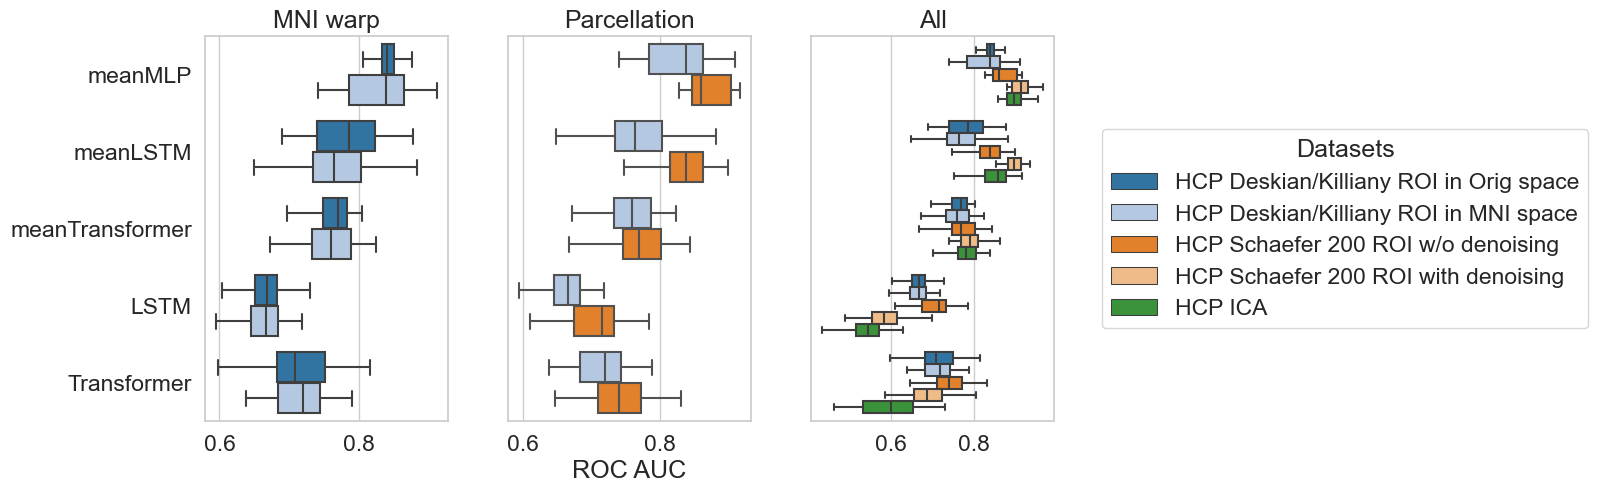

In [107]:
import matplotlib.ticker as ticker
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1.5,
)

# Create a figure and a grid of subplots (2 rows, 1 column)
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 4, width_ratios=[2, 2, 2, 4])

# Create subplots for each subfigure
subfig1 = plt.subplot(gs[0])
subfig2 = plt.subplot(gs[1])
subfig3 = plt.subplot(gs[2])
subfig4 = plt.subplot(gs[3])

boxplot_1 = sns.boxplot(
    x="AUROC", 
    order=x_order,
    y="Model",
    orient="h",
    hue="Dataset",
    hue_order=mni_datasets,
    data=data_1,
    palette=palette,
    showfliers = False,
    ax=subfig1
)
subfig1.set_xlabel(None)
subfig1.set_ylabel(None)
subfig1.set_title("MNI warp")

boxplot_2 = sns.boxplot(
    x="AUROC", 
    order=x_order,
    y="Model",
    orient="h",
    hue="Dataset",
    hue_order=parcellation_datasets,
    data=data_2,
    palette=palette,
    showfliers = False,
    ax=subfig2
)
subfig2.set_yticks([])
subfig2.set_xlabel("ROC AUC")
subfig2.set_ylabel(None)
subfig2.set_title("Parcellation")

boxplot_3 = sns.boxplot(
    x="AUROC", 
    order=x_order,
    y="Model",
    orient="h",
    hue="Dataset",
    hue_order=all_datasets,
    data=data_3,
    palette=palette,
    showfliers = False,
    ax=subfig3
)
subfig3.set_yticks([])
subfig3.set_xlabel(None)
subfig3.set_ylabel(None)
subfig3.set_title("All")

# Plot legend
subfig1.legend_.remove()
subfig2.legend_.remove()
subfig3.legend_.remove()

## plot dummy data
sns.boxplot(
    x="AUROC", 
    order=x_order,
    y="Model",
    orient="h",
    hue="Dataset",
    hue_order=datasets,
    data=plot_data,
    palette=palette,
    showfliers = False,
    ax=subfig4
)
legend_handles, legend_labels = subfig4.get_legend_handles_labels()
## discard plotted data once legend is extracted
subfig4.clear()
subfig4.axis('off')
legend = subfig4.legend(handles=legend_handles,
                        labels=legend_labels, loc='right', title='Datasets')

plt.show()
# plt.savefig(
#     "preprocessing_comparison.svg",
#     format="svg",
#     # dpi=300,
#     bbox_inches='tight',
# )
# plt.savefig(
#     "preprocessing_comparison.png",
#     format="png",
#     dpi=300,
#     bbox_inches='tight',
# )
plt.close()

## Shuffling results

In [155]:
# utility function for hiding everything except xlabel
def hide_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks([])  # Hide y-axis ticks and labels
    ax.xaxis.set_label_coords(0.5, -0.15)  # Adjust the position of the x-label
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_visible(True)  # Make x-axis and x-label visible

In [156]:
models = [
    "meanMLP", 
    # 'meanLSTM',
    # 'meanTransformer',
    'LSTM',
    'Transformer',
]

plot_data = analysis_data.copy(deep=True)

plot_data = plot_data.query(
        "Model in @models")

rename_dict = {'None': 'Original', 'Multiple': 'Broken'}
plot_data = plot_data.query("Shuffling in ['None', 'Multiple']")
plot_data["Shuffling"] = plot_data["Shuffling"].replace(rename_dict)
plot_data = plot_data.rename(columns={'Shuffling': "Temporal order"})

datasets = [
    "HCP Deskian/Killiany ROI in Orig space",
    "HCP Deskian/Killiany ROI",
    "HCP Schaefer 200 ROI w/o denoising",
    "HCP Schaefer 200 ROI",
    "HCP ICA",
    "UK Biobank (Sex) ICA",
]

x_order = models
hue_order = ["Original", "Broken"]

time_data = plot_data.query("Dataset == 'HCP ICA Time'")
time_data = time_data.query("`Temporal order` == 'Original'")

subplot_data = []
for dataset in datasets:
    subplot_data += [plot_data.query("Dataset == @dataset")]

models_palette = { item: plt.cm.tab20(i) for i, item in enumerate(models)}
palette = { item: plt.cm.tab20(i) for i, item in enumerate(hue_order)}

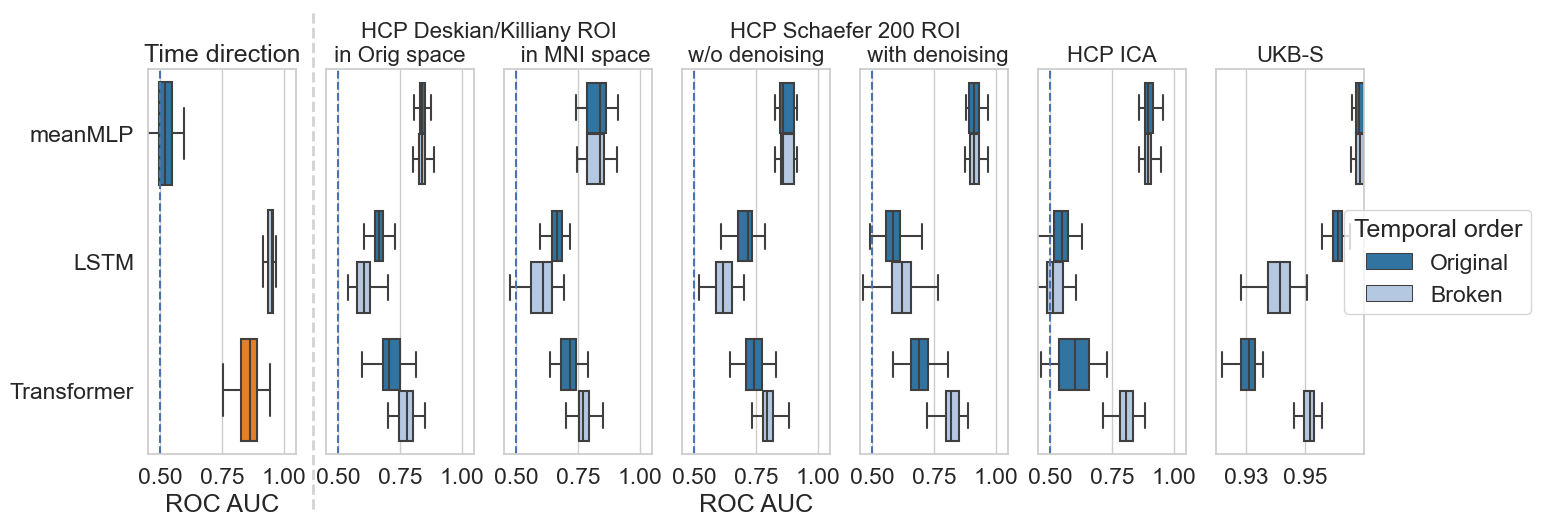

In [115]:
import matplotlib.ticker as ticker
from statannot import add_stat_annotation


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sns.reset_orig()
sns.set_theme(
    style="whitegrid", 
    font_scale = 1.5,
)

# Create a figure and a grid of subplots (2 rows, 1 column)
fig = plt.figure(figsize=(18, 5))
gs = gridspec.GridSpec(1, 2+len(datasets), width_ratios=[1]*(2+len(datasets)))

# Create subplots for each subfigure
subfigs = []
for i in range(2+len(datasets)):
    subfigs += [plt.subplot(gs[i])]

sns.boxplot(
    x="AUROC", 
    order=x_order,
    y="Model",
    orient="h",
    data=time_data,
    palette=models_palette,
    showfliers = False,
    ax=subfigs[0]
)
# subfigs[0].set_xlabel(None)
subfigs[0].set_xticks([0.5, 0.75, 1.0])
subfigs[0].set_xlim([0.45, 1.05])
subfigs[0].set_ylabel(None)
subfigs[0].set_xlabel(None)
subfigs[0].set_title("Time direction")
subfigs[0].axvline(x=0.5, linestyle='dashed')

for subplot_idx in range(1, len(datasets)+1):
    sns.boxplot(
        x="AUROC", 
        order=x_order,
        y="Model",
        orient="h",
        hue="Temporal order",
        hue_order=hue_order,
        data=subplot_data[subplot_idx-1],
        palette=palette,
        showfliers = False,
        ax=subfigs[subplot_idx]
    )
    # subfigs[0].set_xlabel(None)
    if subplot_idx == len(datasets):
        subfigs[subplot_idx].set_xlim([0.92, 0.97])
        subfigs[subplot_idx].set_xticks([0.93, 0.95])
    else:
        subfigs[subplot_idx].set_xticks([0.5, 0.75, 1.0])
        subfigs[subplot_idx].set_xlim([0.45, 1.05])
    subfigs[subplot_idx].set_yticks([])
    subfigs[subplot_idx].set_ylabel(None)
    subfigs[subplot_idx].set_xlabel(None)
    subfigs[subplot_idx].legend_.remove()
    subfigs[subplot_idx].axvline(x=0.5, linestyle='dashed')
    
    # add_stat_annotation(subfigs[subplot_idx], data=subplot_data[subplot_idx-1], x="AUROC", y="Model", hue="Temporal order", hue_order=hue_order,
    #                 box_pairs=[(("LSTM", "Broken"), ("LSTM", "Original"))],
    #                 test='Wilcoxon', text_format='star', loc='inside', verbose=1, text_offset=-4, 
    #                 pvalue_thresholds = [[0.05, "*"], [1, u'\N{DEGREE SIGN}']],
    #                 line_offset=0.01, line_offset_to_box=0.01, line_height=0.01, fontsize=30)

# set titles
fs = 16
title_ax_12 = fig.add_subplot(gs[1:3])
title_ax_12.set_title("HCP Deskian/Killiany ROI\n in Orig space         in MNI space", fontsize=fs)
title_ax_12.axis("off")  # Turn off axis for the title subplot

title_ax_34 = fig.add_subplot(gs[3:5])
title_ax_34.set_title("HCP Schaefer 200 ROI\n w/o denoising       with denoising", fontsize=fs)
title_ax_34.axis("off")  # Turn off axis for the title subplot

subfigs[-3].set_title("HCP ICA", fontsize=fs)
subfigs[-2].set_title("UKB-S", fontsize=fs)

# set x labels
subfigs[0].set_xlabel("ROC AUC")
subfigs[3].set_xlabel("ROC AUC")


# Plot legend
## plot dummy data
sns.boxplot(
    x="AUROC", 
    order=x_order,
    y="Model",
    orient="h",
    hue="Temporal order",
    hue_order=hue_order,
    data=subplot_data[-1],
    palette=palette,
    showfliers = False,
    ax=subfigs[-1]
)
legend_handles, legend_labels = subfigs[-1].get_legend_handles_labels()
## discard plotted data once legend is extracted
subfigs[-1].clear()
subfigs[-1].axis('off')
legend = subfigs[-1].legend(handles=legend_handles,
                        labels=legend_labels, loc='right', title='Temporal order')


### separate time direction results from the rest
line_position = 1.95/9  # Adjust the line position as needed
line = plt.Line2D([line_position, line_position], [0, 1], transform=fig.transFigure, color='lightgrey', linewidth=2, linestyle='dashed')
fig.lines.extend([line])

plt.show()
# plt.savefig(
#     "shuffling_comparison.svg",
#     format="svg",
#     # dpi=300,
#     bbox_inches='tight',
# )
# plt.savefig(
#     "shuffling_comparison.png",
#     format="png",
#     dpi=300,
#     bbox_inches='tight',
# )
plt.close()